# Ablations
> Ablation experiments: angle equidistance and other design choices

In [ ]:
%load_ext autoreload
%autoreload 2

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from time import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from hyperdt.toy_data import wrapped_normal_mixture
from hyperdt.forest import HyperbolicRandomForestClassifier

In [23]:
results = pd.DataFrame(columns=["n_dim", "n_samples", "trial", "midpoint", "score", "time"])

my_tqdm = tqdm(total=4 * 4 * 10)

for n_dim in [2, 4, 8, 16]:
    for n_samples in [100, 200, 400, 800]:
        for trial in range(10):
            X, y = wrapped_normal_mixture(num_points=n_samples, n_dim=n_dim, num_classes=6, seed=trial)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=trial)

            # Midpoint normal
            t1 = time()
            clf_midpoint = HyperbolicRandomForestClassifier(n_estimators=12, max_depth=3, random_state=trial)
            clf_midpoint.fit(X_train, y_train)
            y_pred = clf_midpoint.predict(X_test)
            t2 = time()
            results.loc[len(results)] = [
                n_dim,
                n_samples,
                trial,
                "midpoint",
                f1_score(y_test, y_pred, average="micro"),
                t2 - t1,
            ]

            # Ablated midpoint
            t1 = time()
            clf_ablated = HyperbolicRandomForestClassifier(
                n_estimators=12, max_depth=3, random_state=trial * n_samples, angle_midpoint_method="bisect"
            )
            clf_ablated.fit(X_train, y_train)
            y_pred = clf_ablated.predict(X_test)
            t2 = time()
            results.loc[len(results)] = [
                n_dim,
                n_samples,
                trial,
                "ablated",
                f1_score(y_test, y_pred, average="micro"),
                t2 - t1,
            ]

            my_tqdm.update(1)

results.to_csv("../data/processed/ablations.csv", index=False)

  0%|          | 0/160 [00:00<?, ?it/s]

In [24]:
# Dataframe means

results.groupby(["n_samples", "n_dim", "midpoint"]).mean()

trial     score      time
n_samples n_dim midpoint                           
100       2     ablated     4.5  0.710000  0.100006
                midpoint    4.5  0.670000  0.357334
          4     ablated     4.5  0.890000  0.229401
                midpoint    4.5  0.895000  0.344868
          8     ablated     4.5  0.875000  0.307348
                midpoint    4.5  0.875000  0.471800
          16    ablated     4.5  0.830000  0.571403
                midpoint    4.5  0.820000  0.854103
200       2     ablated     4.5  0.712500  0.134926
                midpoint    4.5  0.700000  0.211094
          4     ablated     4.5  0.885000  0.388432
                midpoint    4.5  0.867500  0.597897
          8     ablated     4.5  0.857500  0.509877
                midpoint    4.5  0.855000  0.788477
          16    ablated     4.5  0.872500  1.046150
                midpoint    4.5  0.880000  1.592128
400       2     ablated     4.5  0.733750  0.252721
                midpoint    4.5  0.742500  0.384333
          4     ablated     4.5  0.903750  0.772227
                midpoint    4.5  0.905000  1.142591
          8     ablated     4.5  0.893750  0.752992
                midpoint    4.5  0.908750  1.111287
          16    ablated     4.5  0.852500  1.884675
                midpoint    4.5  0.852500  2.935638
800       2     ablated     4.5  0.742500  0.757160
                midpoint    4.5  0.741250  1.075954
          4     ablated     4.5  0.888125  1.484057
                midpoint    4.5  0.895000  2.197066
          8     ablated     4.5  0.890625  2.477083
                midpoint    4.5  0.894375  3.407252
          16    ablated     4.5  0.863750  4.201270
                midpoint    4.5  0.876250  5.893740

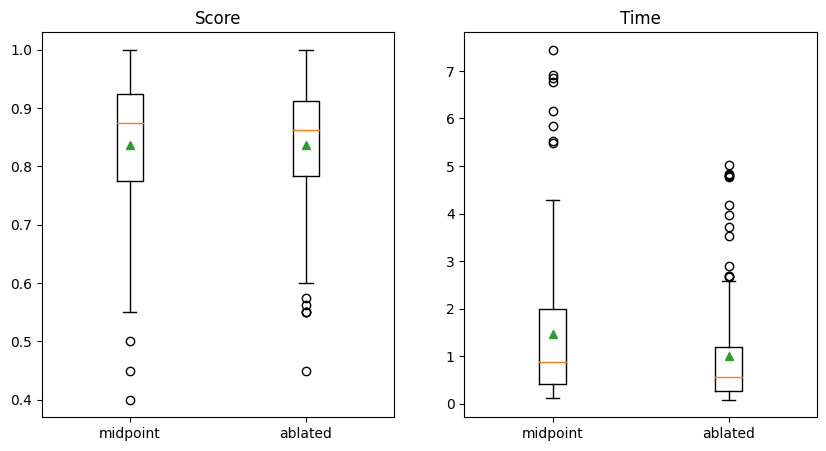

In [31]:
# Boxplot: score

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Score")
plt.boxplot(
    [
        results[results.midpoint == "midpoint"].score,
        results[results.midpoint == "ablated"].score,
    ],
    labels=["midpoint", "ablated"],
    showmeans=True,
)

plt.subplot(1, 2, 2)
plt.title("Time")
plt.boxplot(
    [
        results[results.midpoint == "midpoint"].time,
        results[results.midpoint == "ablated"].time,
    ],
    labels=["midpoint", "ablated"],
    showmeans=True,
)
plt.show()

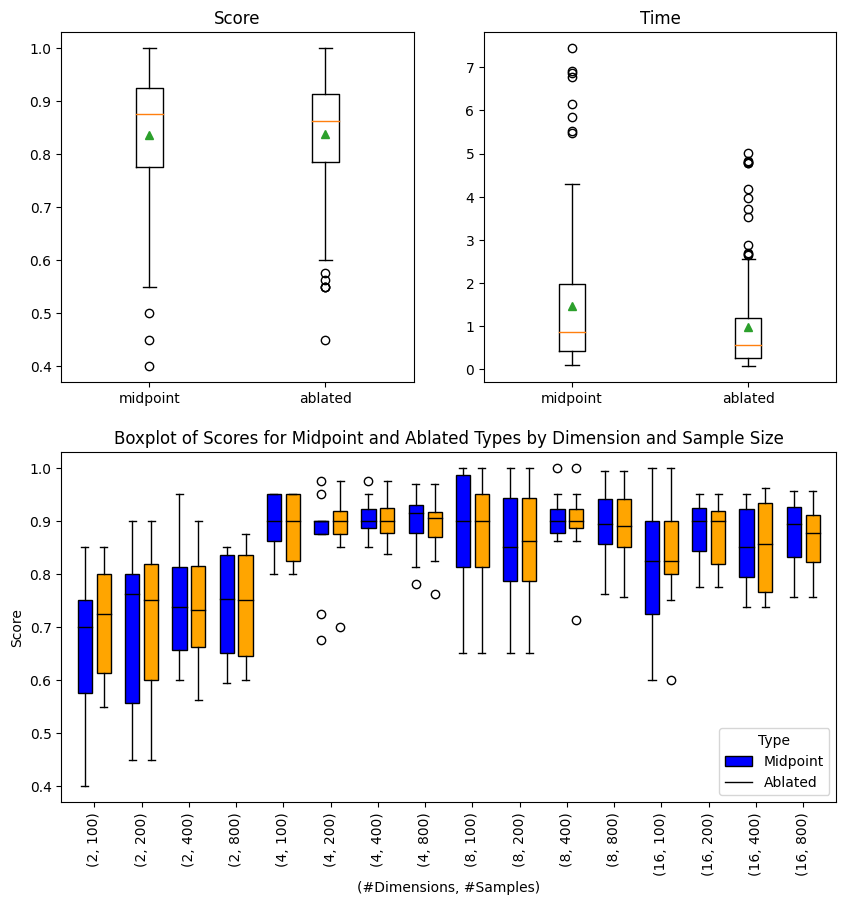

In [58]:
# Ablations: grouped by dim, samples
fig, ax = plt.subplot_mosaic("ab;cc", figsize=(10, 10))

# Boxplot: score, aggregated
ax["a"].set_title("Score")
ax["a"].boxplot(
    [results[results.midpoint == "midpoint"].score, results[results.midpoint == "ablated"].score],
    labels=["midpoint", "ablated"],
    showmeans=True,
)

# Boxplot: time, aggregated
ax["b"].set_title("Time")
ax["b"].boxplot(
    [results[results.midpoint == "midpoint"].time, results[results.midpoint == "ablated"].time],
    labels=["midpoint", "ablated"],
    showmeans=True,
)

# Filtering the data for 'midpoint' and 'ablated' types
midpoint_data = results[results["midpoint"] == "midpoint"]
ablated_data = results[results["midpoint"] == "ablated"]

# Unique n_dim and n_samples values for grouping
n_dims = results["n_dim"].unique()
n_samples = results["n_samples"].unique()

# Plotting each pair of 'midpoint' and 'ablated' for each (n_dim, n_samples) pair
for n_dim in n_dims:
    for n_sample in n_samples:
        # Filter data for current n_dim and n_samples
        midpoint_scores = midpoint_data[midpoint_data["n_dim"] == n_dim]
        midpoint_scores = midpoint_scores[midpoint_scores["n_samples"] == n_sample]
        midpoint_scores = midpoint_scores["score"]

        ablated_scores = ablated_data[ablated_data["n_dim"] == n_dim]
        ablated_scores = ablated_scores[ablated_scores["n_samples"] == n_sample]
        ablated_scores = ablated_scores["score"]

        # Position for the box plots
        pos = len(n_samples) * (n_dims.tolist().index(n_dim)) + n_samples.tolist().index(n_sample)

        # Drawing the box plots
        bp = ax["c"].boxplot(
            [midpoint_scores, ablated_scores], positions=[pos - 0.2, pos + 0.2], widths=0.3, patch_artist=True
        )

        # Setting colors for the two types
        colors = ["blue", "orange"]
        for patch, color in zip(bp["boxes"], colors):
            patch.set_facecolor(color)

        # Set median colors
        for median in bp["medians"]:
            median.set(color="black", linewidth=1)

# Customizing the axes
ax["c"].set_xticks(range(len(n_dims) * len(n_samples)))
ax["c"].set_xticklabels([f"({dim}, {sample})" for dim in n_dims for sample in n_samples], rotation=90)
ax["c"].set_xlabel("(#Dimensions, #Samples)")
ax["c"].set_ylabel("Score")
ax["c"].set_title("Boxplot of Scores for Midpoint and Ablated Types by Dimension and Sample Size")
plt.legend(["Midpoint", "Ablated"], title="Type")
plt.show()